In [1]:
import pandas as pd
import numpy as np

import yfinance as yf

In [2]:
import seaborn as sns

import matplotlib.pyplot as plt

In [3]:
# Even though AAPL was listed in 1980, We want to exclude the timeline of dotcom bubble
# Because it can impact our forecasts and we'll still have ample data if we start from 2002

df = yf.download('AAPL', start = '2002-01-01')

[*********************100%***********************]  1 of 1 completed


In [4]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2002-01-02,0.393750,0.416071,0.392143,0.416071,0.353160,529496800
2002-01-03,0.410714,0.424107,0.406607,0.421071,0.357404,612007200
2002-01-04,0.416786,0.427679,0.410536,0.423036,0.359071,409976000
2002-01-07,0.423571,0.428571,0.406250,0.408929,0.347097,444584000
2002-01-08,0.406250,0.411607,0.401071,0.403750,0.342702,450038400


## 1.) What was the change in price of the stock over time?

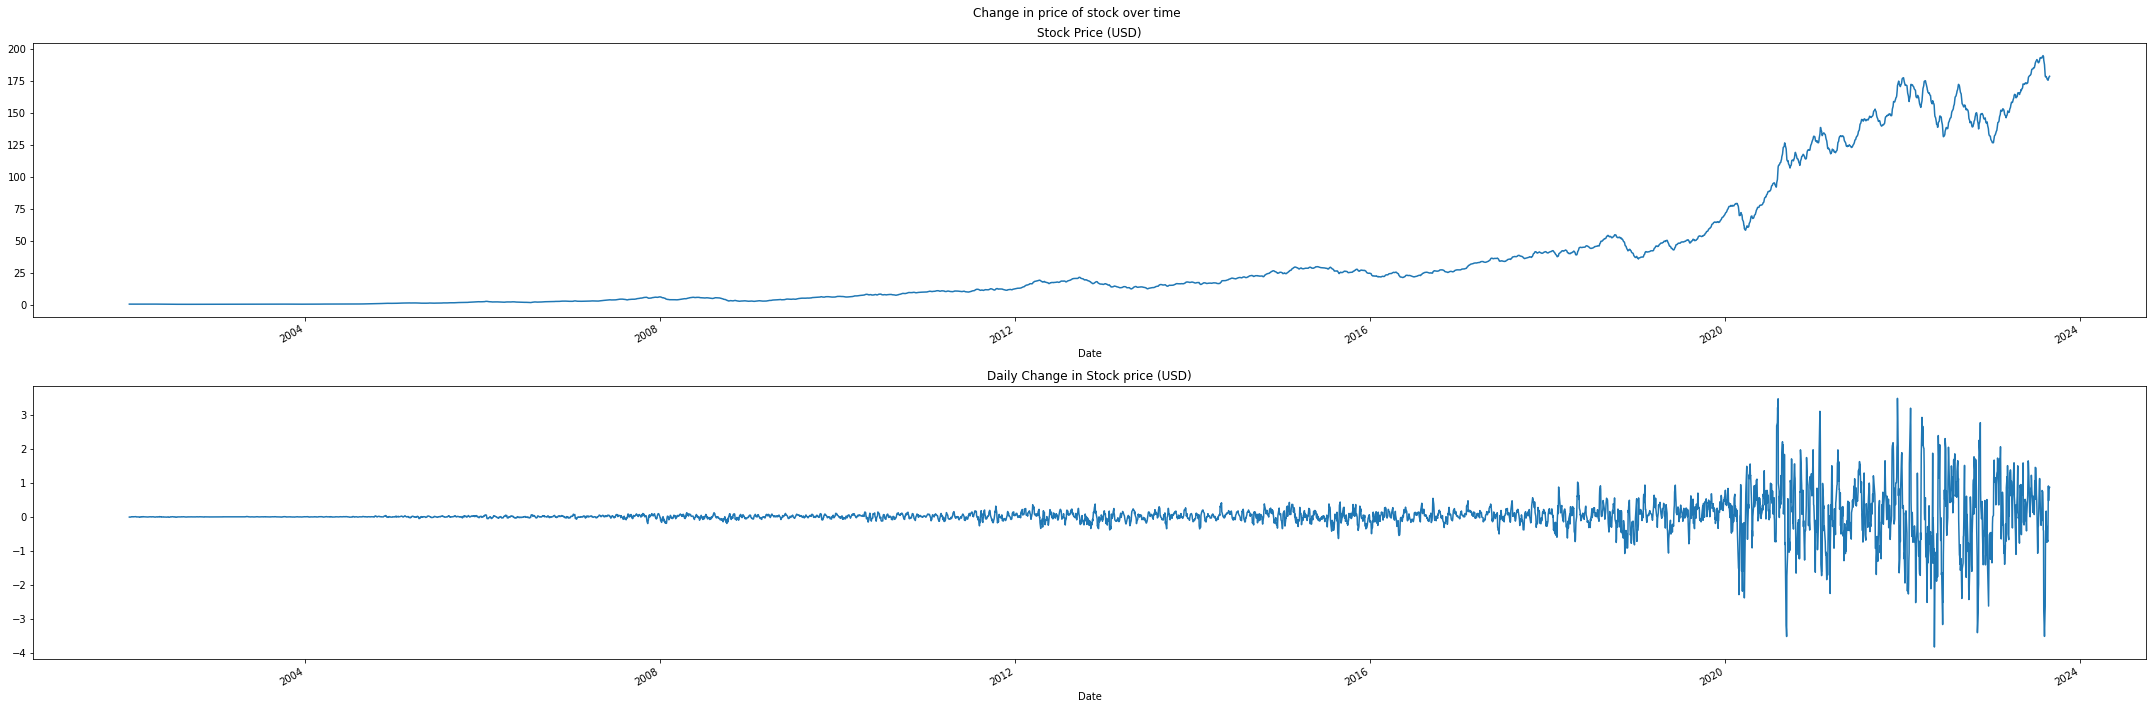

In [5]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize = (30, 10))  # Create a 2x1 grid of subplots

# Plot the columns of DataFrame on subplots
df['Adj Close'].rolling(window = 5).mean().plot(ax=axes[0])  # Plot column 'Adj Close' on the top subplot
(df['Adj Close'] - df['Adj Close'].shift(1)).rolling(window = 5).mean().plot(ax = axes[1])  # Plot daily returns on the bottom subplot

axes[0].set_title('Stock Price (USD)')
axes[1].set_title('Daily Change in Stock price (USD)')
fig.suptitle('Change in price of stock over time')
plt.tight_layout()

# Display the plots
plt.show()

### Here we can see that as the stock price has increased i.e., the daily difference in prices has also increases. Since the price of AAPL is now around 200 USD, an x\% change will lead to a higher price diff than when the stock price was at USD 10

## 2.) What was the daily return of the stock on average?

In [6]:
df['Retx'] = np.log(df['Adj Close'] / df['Adj Close'].shift(1))
df.dropna(inplace = True)
df.head()

,Open,High,Low,Close,Adj Close,Volume,Retx
Date,,,,,,,
2002-01-03,0.410714,0.424107,0.406607,0.421071,0.357404,612007200,0.011946
2002-01-04,0.416786,0.427679,0.410536,0.423036,0.359071,409976000,0.004656
2002-01-07,0.423571,0.428571,0.406250,0.408929,0.347097,444584000,-0.033916
2002-01-08,0.406250,0.411607,0.401071,0.403750,0.342702,450038400,-0.012746
2002-01-09,0.407143,0.409464,0.380000,0.386607,0.328151,327835200,-0.043387


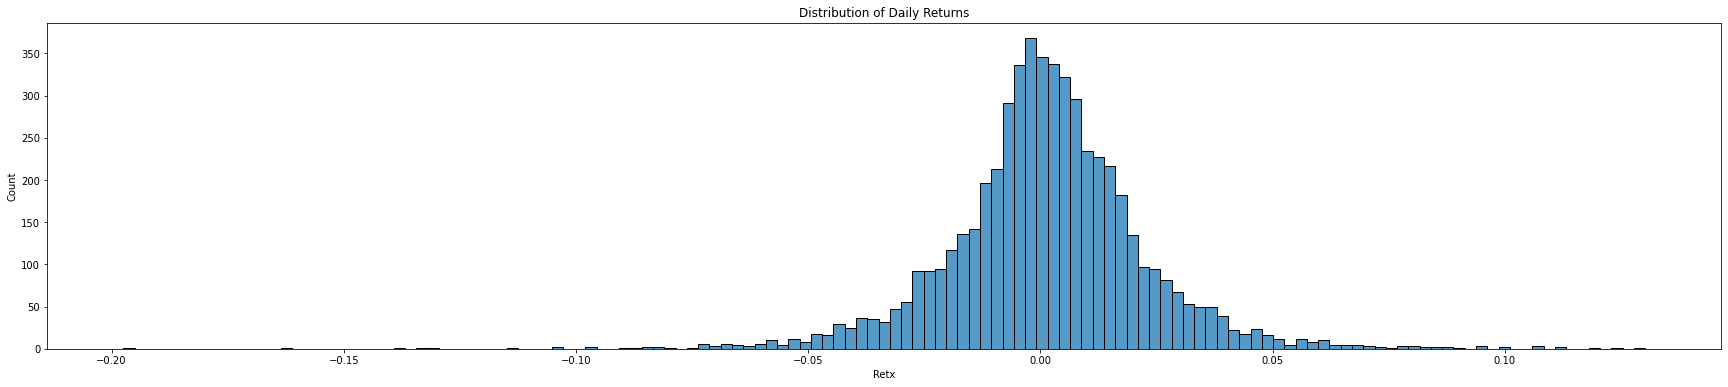

In [7]:
plt.figure(figsize = (30,6))
sns.histplot(df.Retx)
plt.title('Distribution of Daily Returns')
plt.show()

In [8]:
print(f'The mean daily returns = {round(np.mean(df.Retx) * 100, 4)} %')
print(f'The median daily returns = {round(np.median(df.Retx) * 100, 4)} %')
print(f'The std of daily returns = {round(np.std(df.Retx) * 100, 4)} %')

The mean daily returns = 0.1144 %
The median daily returns = 0.0977 %
The std of daily returns = 2.1561 %


## 3.) What was the moving average of the various stocks?

In [9]:
stock_list = ['AAPL', 'MSFT', 'GOOG', 'CRM', 'NVDA', 'AMZN']

ma_stocks = pd.DataFrame()
for i in stock_list:
    ma_stocks[i] = yf.download(i, start = '2002-01-01')['Adj Close']

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


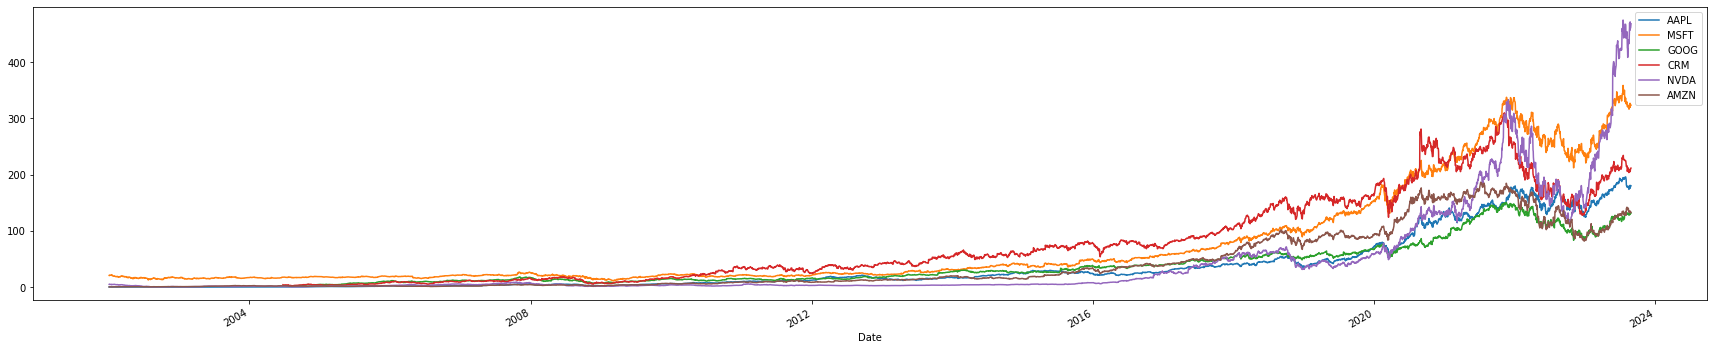

In [10]:
ma_stocks.plot(figsize = (30, 6))
plt.show()

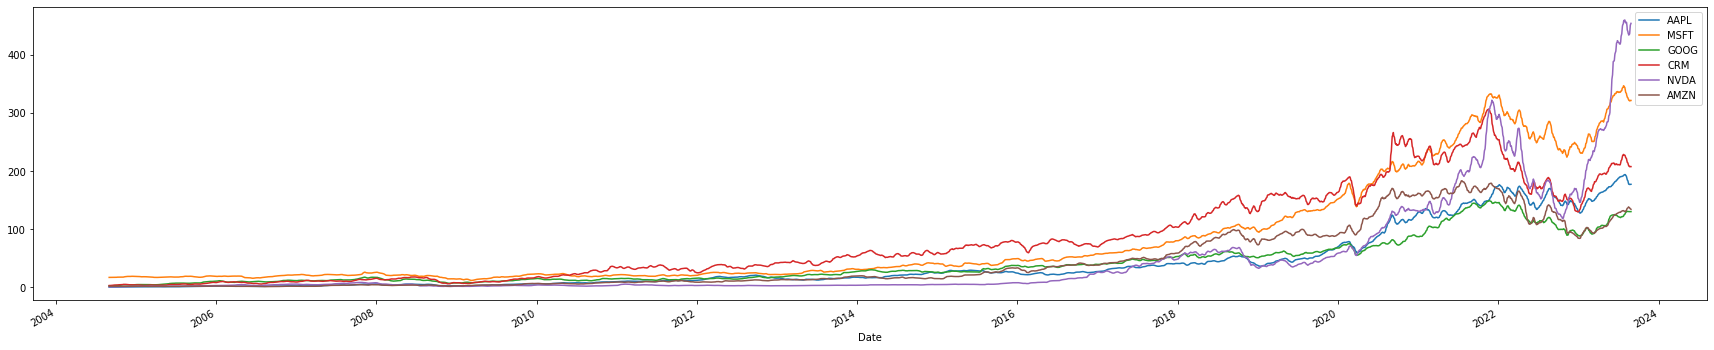

In [11]:
ma_df = ma_stocks.rolling(window = 10).mean().dropna()
ma_df.plot(figsize = (30, 6))
plt.show()

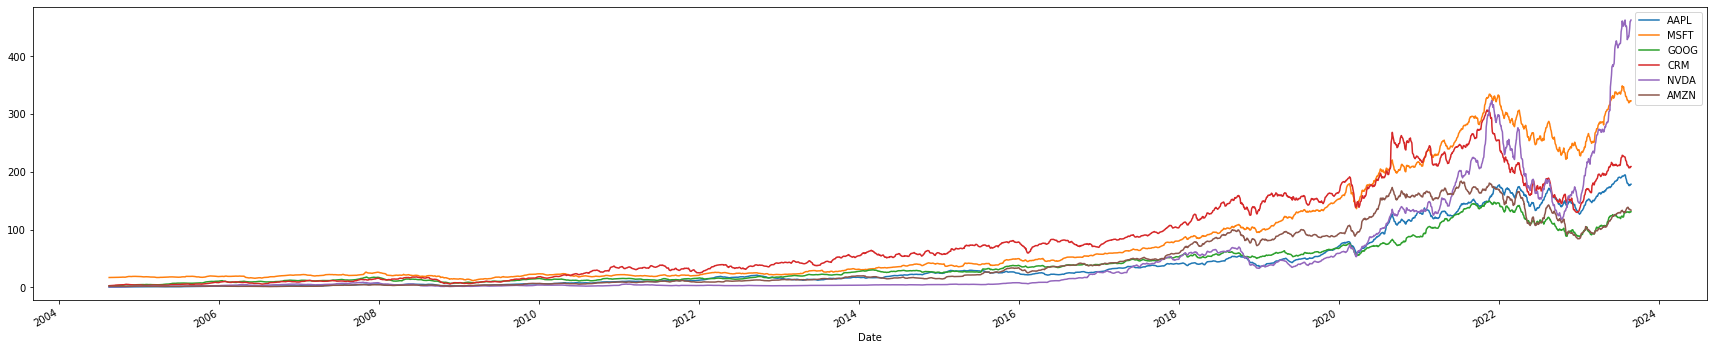

In [12]:
ma_df = ma_stocks.ewm(alpha = 0.3).mean().dropna()
ma_df.plot(figsize = (30, 6))
plt.show()

## 4.) What was the correlation between different stocks?

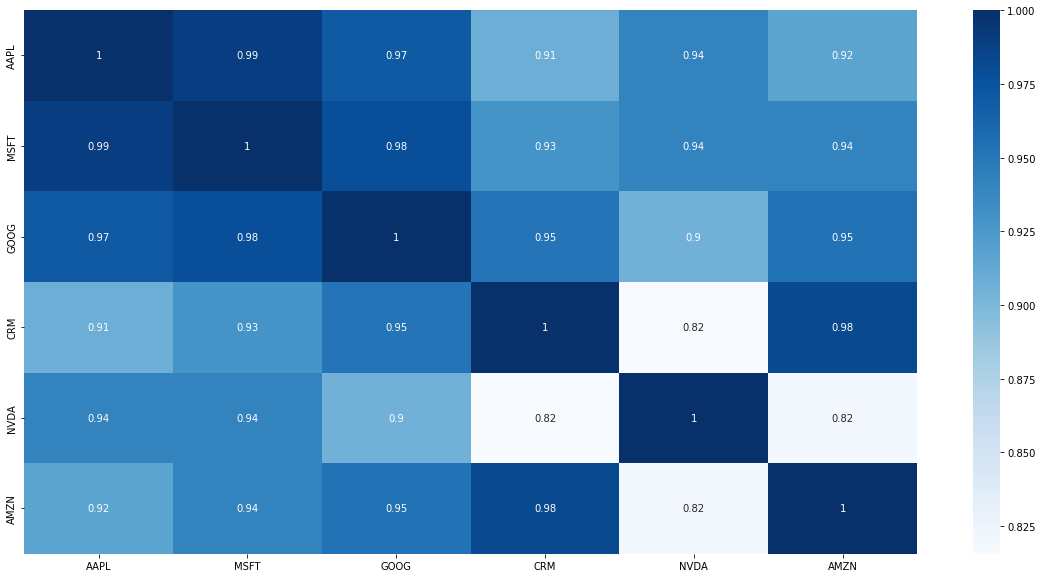

In [13]:
plt.figure(figsize = (20, 10))
sns.heatmap(ma_df.corr(), annot = True, cmap = 'Blues')
plt.show()

### Since we studied the technology-based stocks, we can see that the stocks in same industry are closely related. However if we had seen negative corelation between stocks, we could've opted for a pairs trade

## 5.) How much value do we put at risk by investing in a particular stock?

#### We can calculate the value we put at risk using the VaR calculations 
#### VaR is defined as the probability of losing atleast $x over a particular time frame
#### Ex: If a stock has a 5% one-day VaR of USD 500, it means there's a 5% chance that the stock will loose at least USD 500

In [14]:
import numpy as np

def calculate_portfolio_historical_var(portfolio_returns, portfolio_value, confidence_level=0.95):
    # Calculate the mean and standard deviation of portfolio returns
    portfolio_mean_return = np.mean(portfolio_returns)
    portfolio_std_dev = np.std(portfolio_returns)

    # Define the Z-score at the chosen confidence level    
    z_score = np.abs(np.percentile(portfolio_returns, 100 - confidence_level * 100))

    # Calculate VaR
    var = portfolio_value * np.abs(portfolio_mean_return - z_score * portfolio_std_dev)
    
    return var

for i in stock_list:
    portfolio_returns = (np.log(ma_stocks[i] / ma_stocks[i].shift(1))).dropna().to_list()
    portfolio_value = 1000000  # Replace this with the total value of the portfolio
    confidence_level = 0.90  # Replace this with the desired confidence level (e.g., 0.95 for 95%)
    portfolio_var = calculate_portfolio_historical_var(portfolio_returns, portfolio_value, confidence_level)
    print(f"1-Day VaR at {confidence_level*100:.2f}% confidence level: ${portfolio_var:.2f} for stock {i}")


1-Day VaR at 90.00% confidence level: $647.12 for stock AAPL
1-Day VaR at 90.00% confidence level: $184.42 for stock MSFT
1-Day VaR at 90.00% confidence level: $449.86 for stock GOOG
1-Day VaR at 90.00% confidence level: $83.34 for stock CRM
1-Day VaR at 90.00% confidence level: $334.35 for stock NVDA
1-Day VaR at 90.00% confidence level: $370.07 for stock AMZN


#### Here we can see that CRM (Salesforce) has the lowest daily VAR at 90% and hence is the lowest-risk investments based on 'historical' VaR

## 6.) How can we attempt to predict future stock behavior? (Predicting the closing price stock price of APPLE inc using LSTM, a structured that can be used in Neural Network model)

<AxesSubplot:xlabel='Date'>

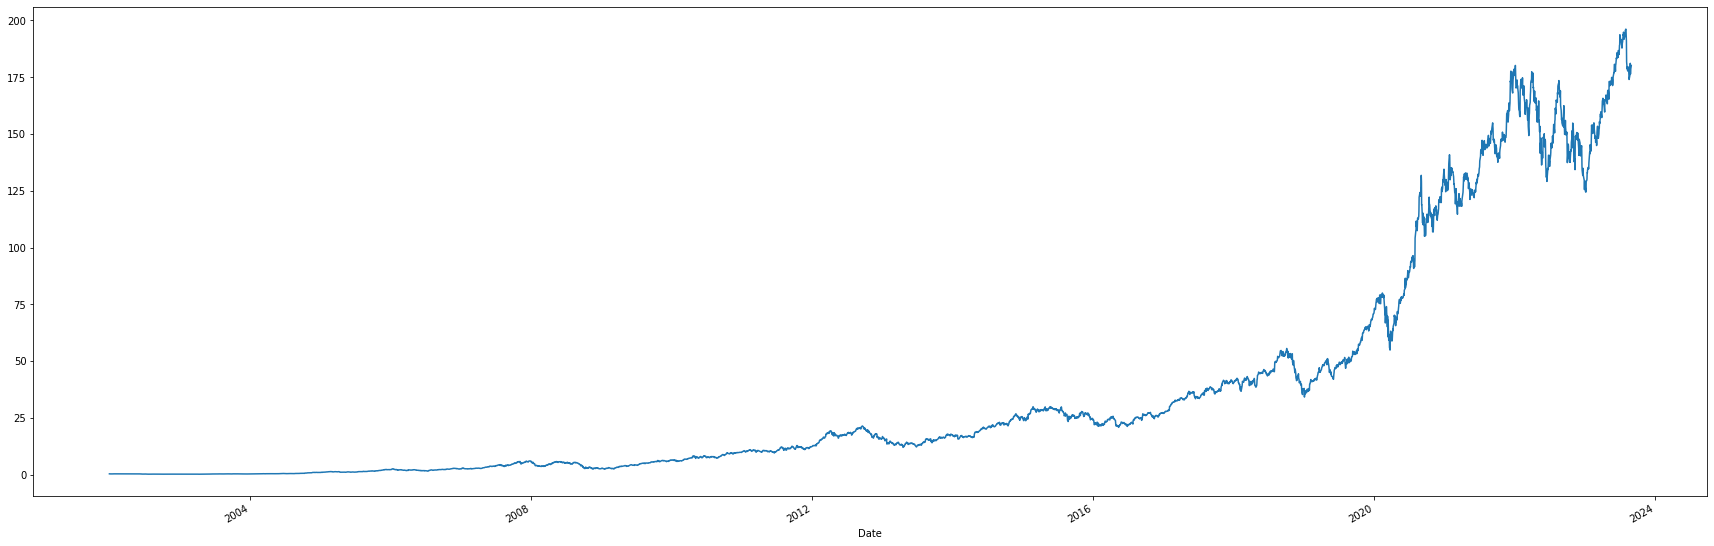

In [15]:
df1 = df['Adj Close']
df1.plot(figsize = (30, 10))

In [16]:
# LSTM are sensitive to the scale of the data. so we must apply MinMax scaler
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0, 1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1,1))

In [17]:
# Train test split
train_size = int(len(df1) * 0.80)
train_data,test_data = df1[0:train_size, :],df1[train_size:len(df1), :1]

In [18]:
#Data Preprocessing
def create_ds(dataset, time_steps):   #Time Steps is how many previous days considered to predict the day price
    data_x,data_y = [], []
    for i in range(len(dataset) - time_steps - 1):
        a = dataset[i : (i + time_steps), 0]
        data_x.append(a)
        b = dataset[i + time_steps, 0]
        data_y.append(b)
    return np.array(data_x), np.array(data_y)

In [19]:
time_step = 80
X_train, y_train = create_ds(train_data, time_step)
X_test, ytest = create_ds(test_data, time_step)

In [20]:
# Reshape input to be [samples, time steps, features] which is required for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [21]:
#Model Creation 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

model=Sequential()
model.add(LSTM(75, return_sequences = True, input_shape = (time_step,1)))
model.add(LSTM(100, return_sequences = True)) 
model.add(LSTM(50, return_sequences = True))
model.add(LSTM(30))
model.add(Dense(1))

model.compile(loss = 'mean_squared_error', optimizer = 'adam')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 80, 75)            23100     
                                                                 
 lstm_1 (LSTM)               (None, 80, 100)           70400     
                                                                 
 lstm_2 (LSTM)               (None, 80, 50)            30200     
                                                                 
 lstm_3 (LSTM)               (None, 30)                9720      
                                                                 
 dense (Dense)               (None, 1)                 31        
                                                                 
Total params: 133,451
Trainable params: 133,451
Non-trainable params: 0
_________________________________________________________________


In [22]:
model.fit(
    X_train, y_train, validation_data = (X_test,ytest), 
    epochs = 25, batch_size = 64, verbose = 1
)

Epoch 1/25
67/67 [==============================] - 10s 52ms/step - loss: 4.1644e-04 - val_loss: 0.0126
Epoch 2/25
67/67 [==============================] - 2s 32ms/step - loss: 3.3687e-05 - val_loss: 0.0089
Epoch 3/25
67/67 [==============================] - 2s 33ms/step - loss: 3.4370e-05 - val_loss: 0.0077
Epoch 4/25
67/67 [==============================] - 2s 32ms/step - loss: 2.9076e-05 - val_loss: 0.0059
Epoch 5/25
67/67 [==============================] - 2s 35ms/step - loss: 2.9082e-05 - val_loss: 0.0084
Epoch 6/25
67/67 [==============================] - 2s 34ms/step - loss: 2.6671e-05 - val_loss: 0.0069
Epoch 7/25
67/67 [==============================] - 2s 33ms/step - loss: 2.5387e-05 - val_loss: 0.0051
Epoch 8/25
67/67 [==============================] - 2s 33ms/step - loss: 2.5006e-05 - val_loss: 0.0032
Epoch 9/25
67/67 [==============================] - 2s 33ms/step - loss: 2.1310e-05 - val_loss: 0.0054
Epoch 10/25
67/67 [==============================] - 2s 33ms/step - loss

In [23]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

32/32 [==============================] - 0s 11ms/step


In [24]:
# We have scaled it, so we need to reverse scale it to find the o/p
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [25]:
#rmse
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train, train_predict))

18.913687361126563

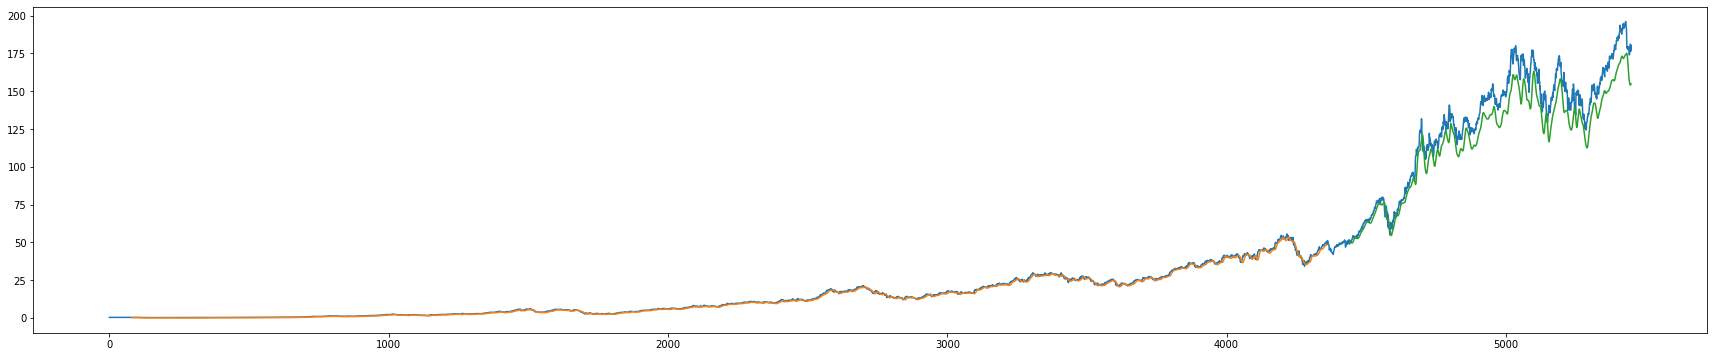

In [26]:
plt.figure(figsize = (30, 6))
plt.plot(scaler.inverse_transform(df1))

look_back = time_step
trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict) + look_back, :] = train_predict
plt.plot(trainPredictPlot)

testPredictPlot = np.empty_like(df1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict) + (look_back * 2) + 1:len(df1) - 1, :] = test_predict
plt.plot(testPredictPlot)

#### Predicting future 10 days

In [27]:
#For predicting next day after last test data, we need to take previous 75 values(timestep)
x_input = test_data[-1 * time_step:].reshape(1, -1)
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

In [28]:
from numpy import array

lst_output = []
n_steps = time_step
i = 0
while(i < 10):
    if(len(temp_input) > 80):
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i = i + 1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i = i + 1

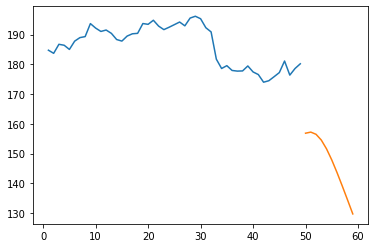

In [29]:
day_new = np.arange(1, 50)
day_pred = np.arange(50, 60)
plt.plot(day_new,scaler.inverse_transform(df1[-49:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

#### The next 10 days are showing a downward trend 

## 7) How can you make Neural Network model (e.g. LSTM) more interpretable?

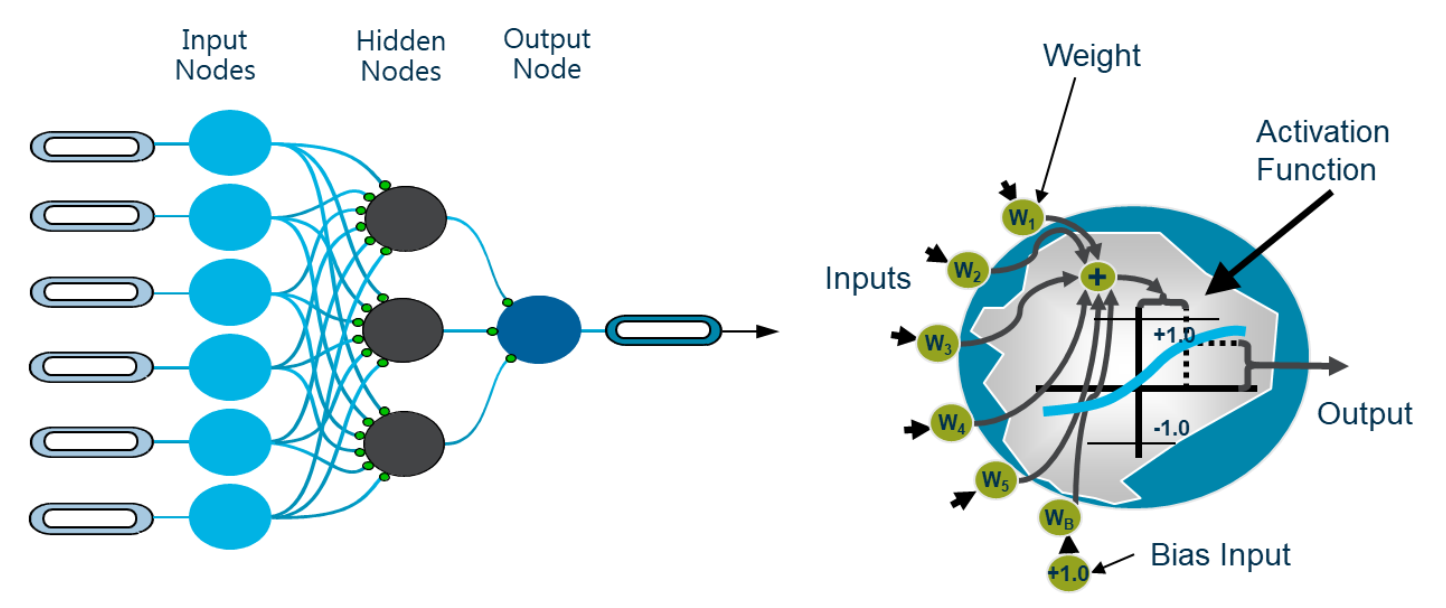

In [30]:
from IPython import display
display.Image("C:\\Users\\jasme\\OneDrive\\Pictures\\Screenshots\\im3.png", width = 1000)

For understanding the interpretability of models, let's go over the general structure of a artificial neural network. It has input nodes which refer to the columns in our data. The input data is passed through hidden layers which perform the calculation (which is similar to linear regression) i.e., wT.X + b. Once we have the result of the calculation, we pass it through an activation function (can be tan(x), sigmoid(x), ReLU(x) or any other function) which will give us the output of one neuron (one processing unit), outputs of each neuron in one layer is aggregated and passed to further neurons. 

Step-by-step the input is propogated through the hidden layers and then finally, the output is calculated. Then we take the output and compare it again the true value to calculate the losses. 

Once loss is calculated, back-propogration is carried out which updates the 'w' in the wT.X + b equation. This process continues till the output converges to true value and we save the final weights and the model. 

Understanding the structure helps us interpret how Neural networks work.